In [11]:
%matplotlib inline
from skimage.feature import peak_local_max
import matplotlib.pyplot as plt
import numpy as np
import tifffile
from numpy.fft import fft
from scipy import ndimage
from skimage.color import label2rgb
from skimage.morphology import disk, erosion
from skimage.segmentation import watershed
from skimage import filters

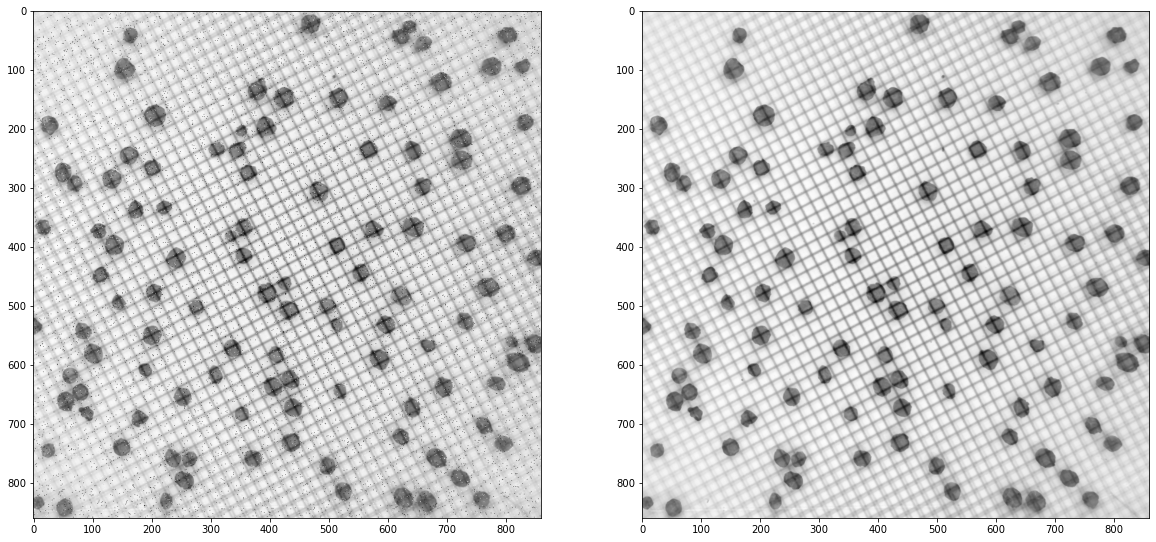

In [4]:
input = tifffile.imread('input.tif')
fig, ax = plt.subplots(ncols=2, figsize=(20, 10))

#Remove salt and petter noise
denoised_image = ndimage.median_filter(input, 3)

ax[0].imshow(input, cmap="gray")
ax[1].imshow(denoised_image, cmap="gray")

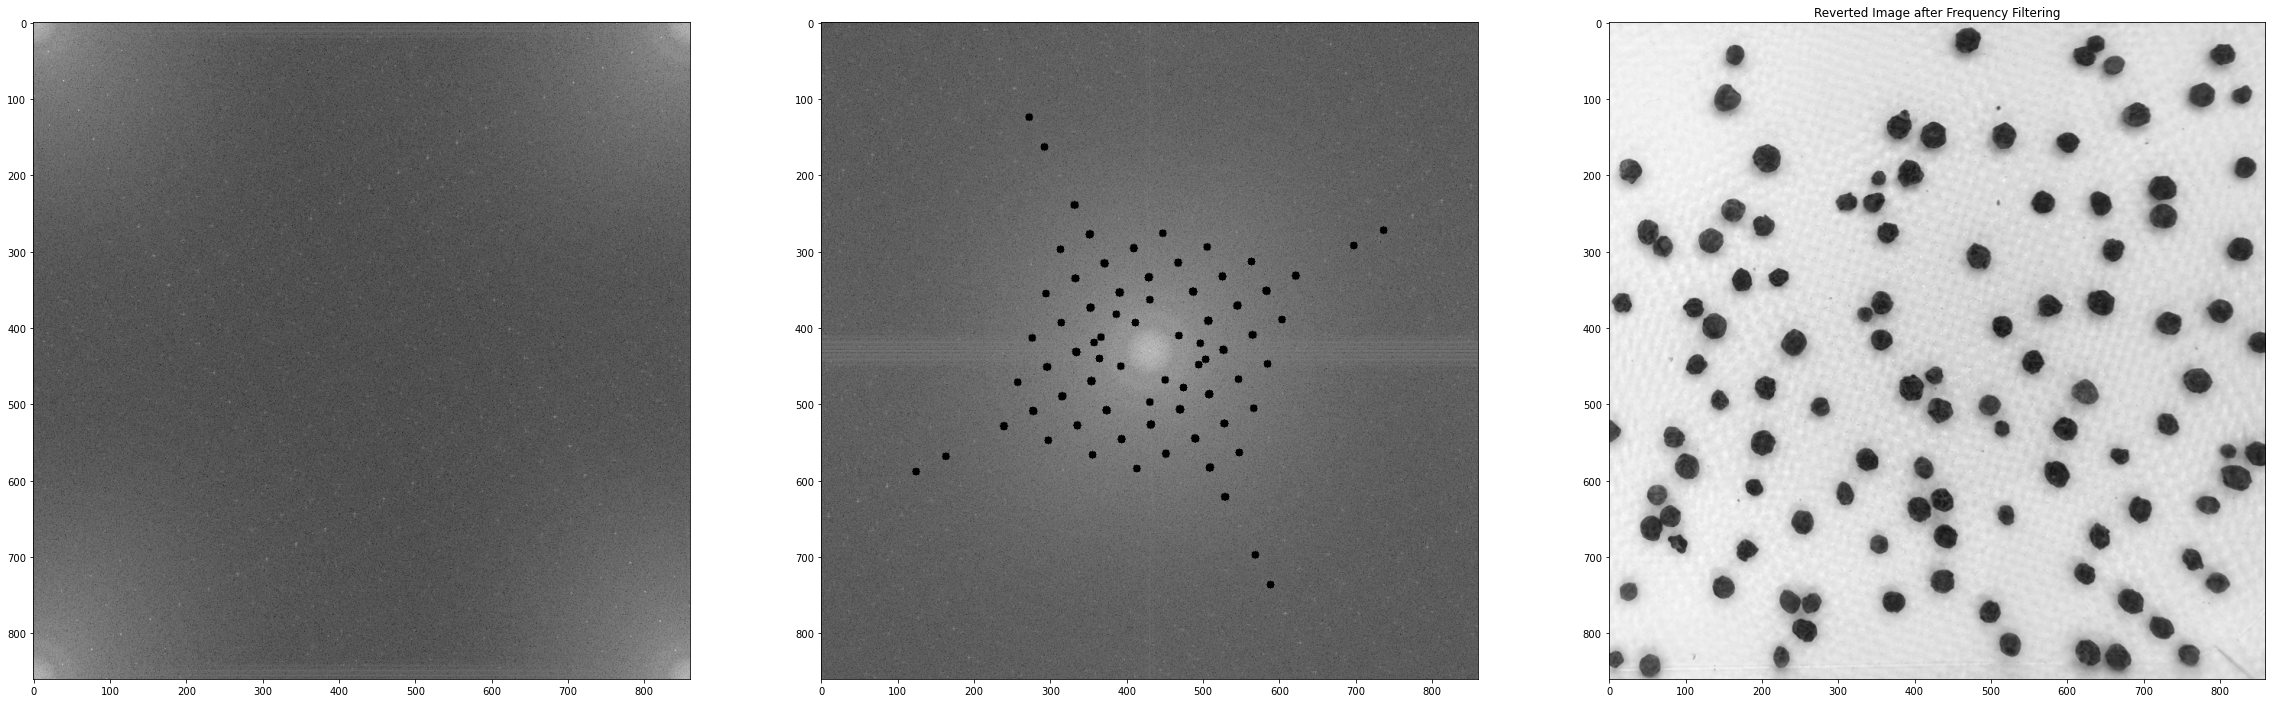

In [26]:
fig, ax = plt.subplots(ncols=2, figsize=(20, 10))

img_c2 = np.fft.fft2(denoised_image)

img_c3 = np.fft.fftshift(img_c2)

# Calculate mask (Masking of a circle in the center to keep important frequencies)
rows, cols = input.shape
crow, ccol = int(rows / 2), int(cols / 2)
r = 65
mask = np.ones_like(input)
center = [crow, ccol]
x, y = np.ogrid[:rows, :cols]
mask_area = (x - center[0]) ** 2 + (y - center[1]) ** 2 <= r * r
mask[mask_area] = 0
# Remove high frequencies in images (corresponding to lines)
filter = np.abs(img_c3 * mask) < 75000
# Manually added some frequencies, which belongs to lines
filter[393, 411] = 0
filter[450, 392] = 0
filter[468, 450] = 0
filter[410, 468] = 0
filter = erosion(filter, disk(5))

img_c3 = img_c3 * filter

img_c4 = np.fft.ifftshift(img_c3)

img_c5 = np.fft.ifft2(img_c4)

ax[1].imshow(np.log(1 + np.abs(img_c3)**2), "gray")
ax[2].set_title("Reverted Image after Frequency Filtering")
ax[2].imshow(img_c5.real, "gray")

161


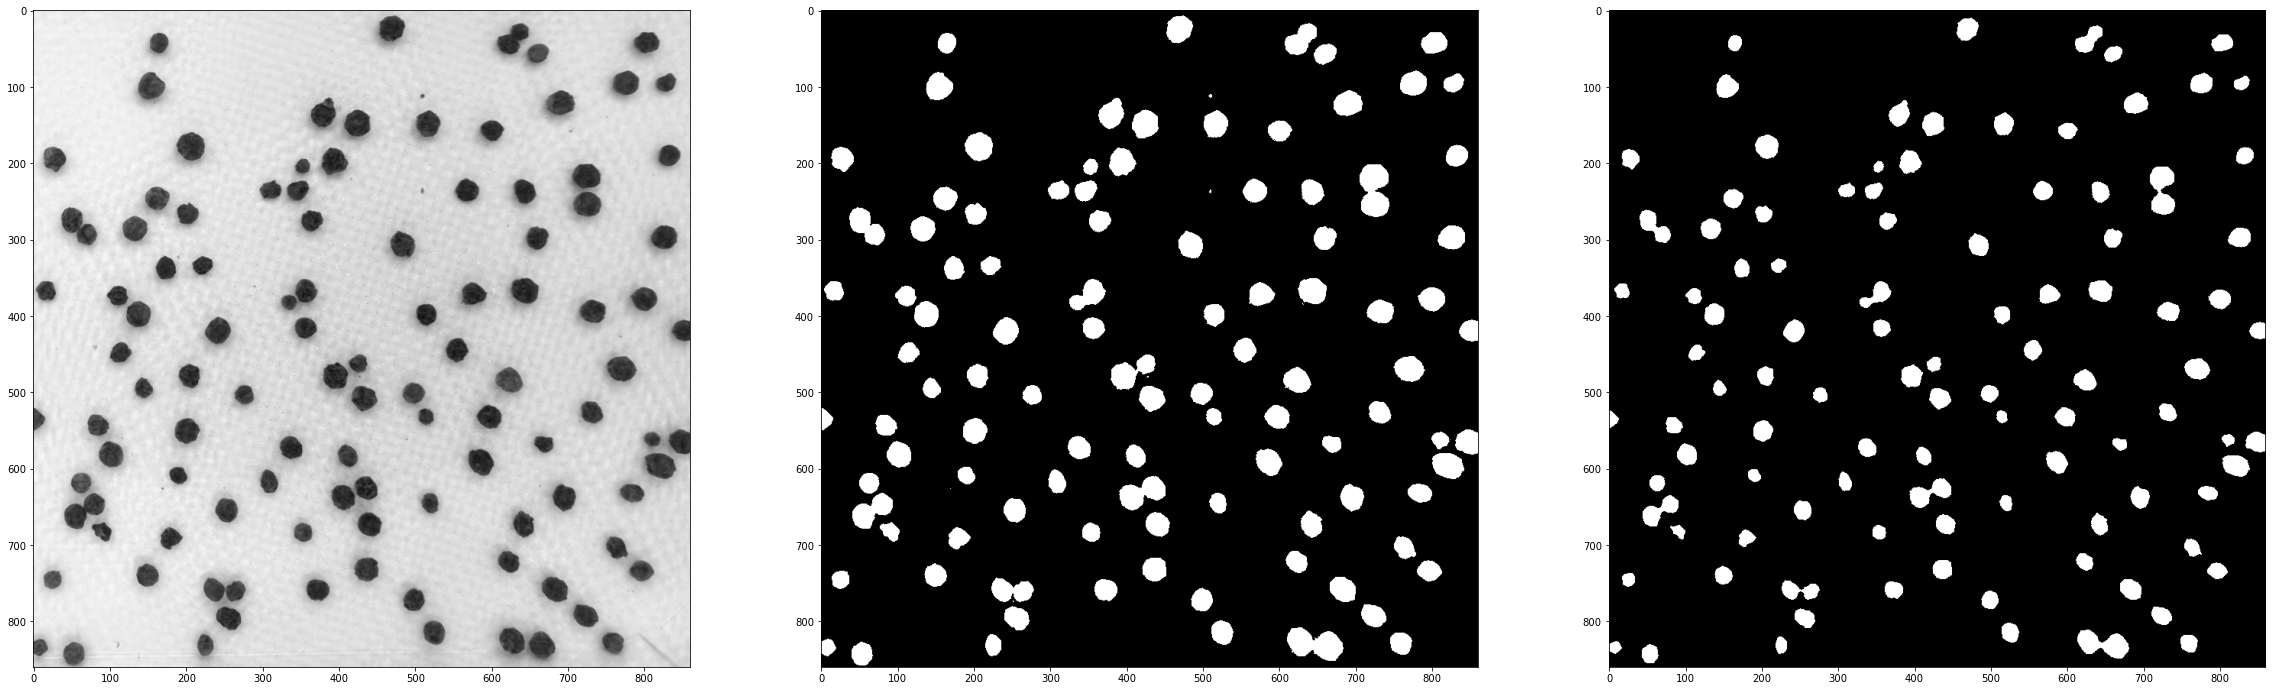

In [17]:

fig, ax = plt.subplots(ncols=3, figsize=(40, 20))

image_no_grid = img_c5.real.astype(int)

footprint = disk(3)

otsu_thresh = filters.threshold_otsu(image_no_grid)

print(otsu_thresh)

bin_image = image_no_grid < otsu_thresh

erroded_bin_image = erosion(bin_image, footprint)

ax[0].imshow(image_no_grid, "gray")
ax[1].imshow(bin_image, "gray")
ax[2].imshow(erroded_bin_image, "gray")

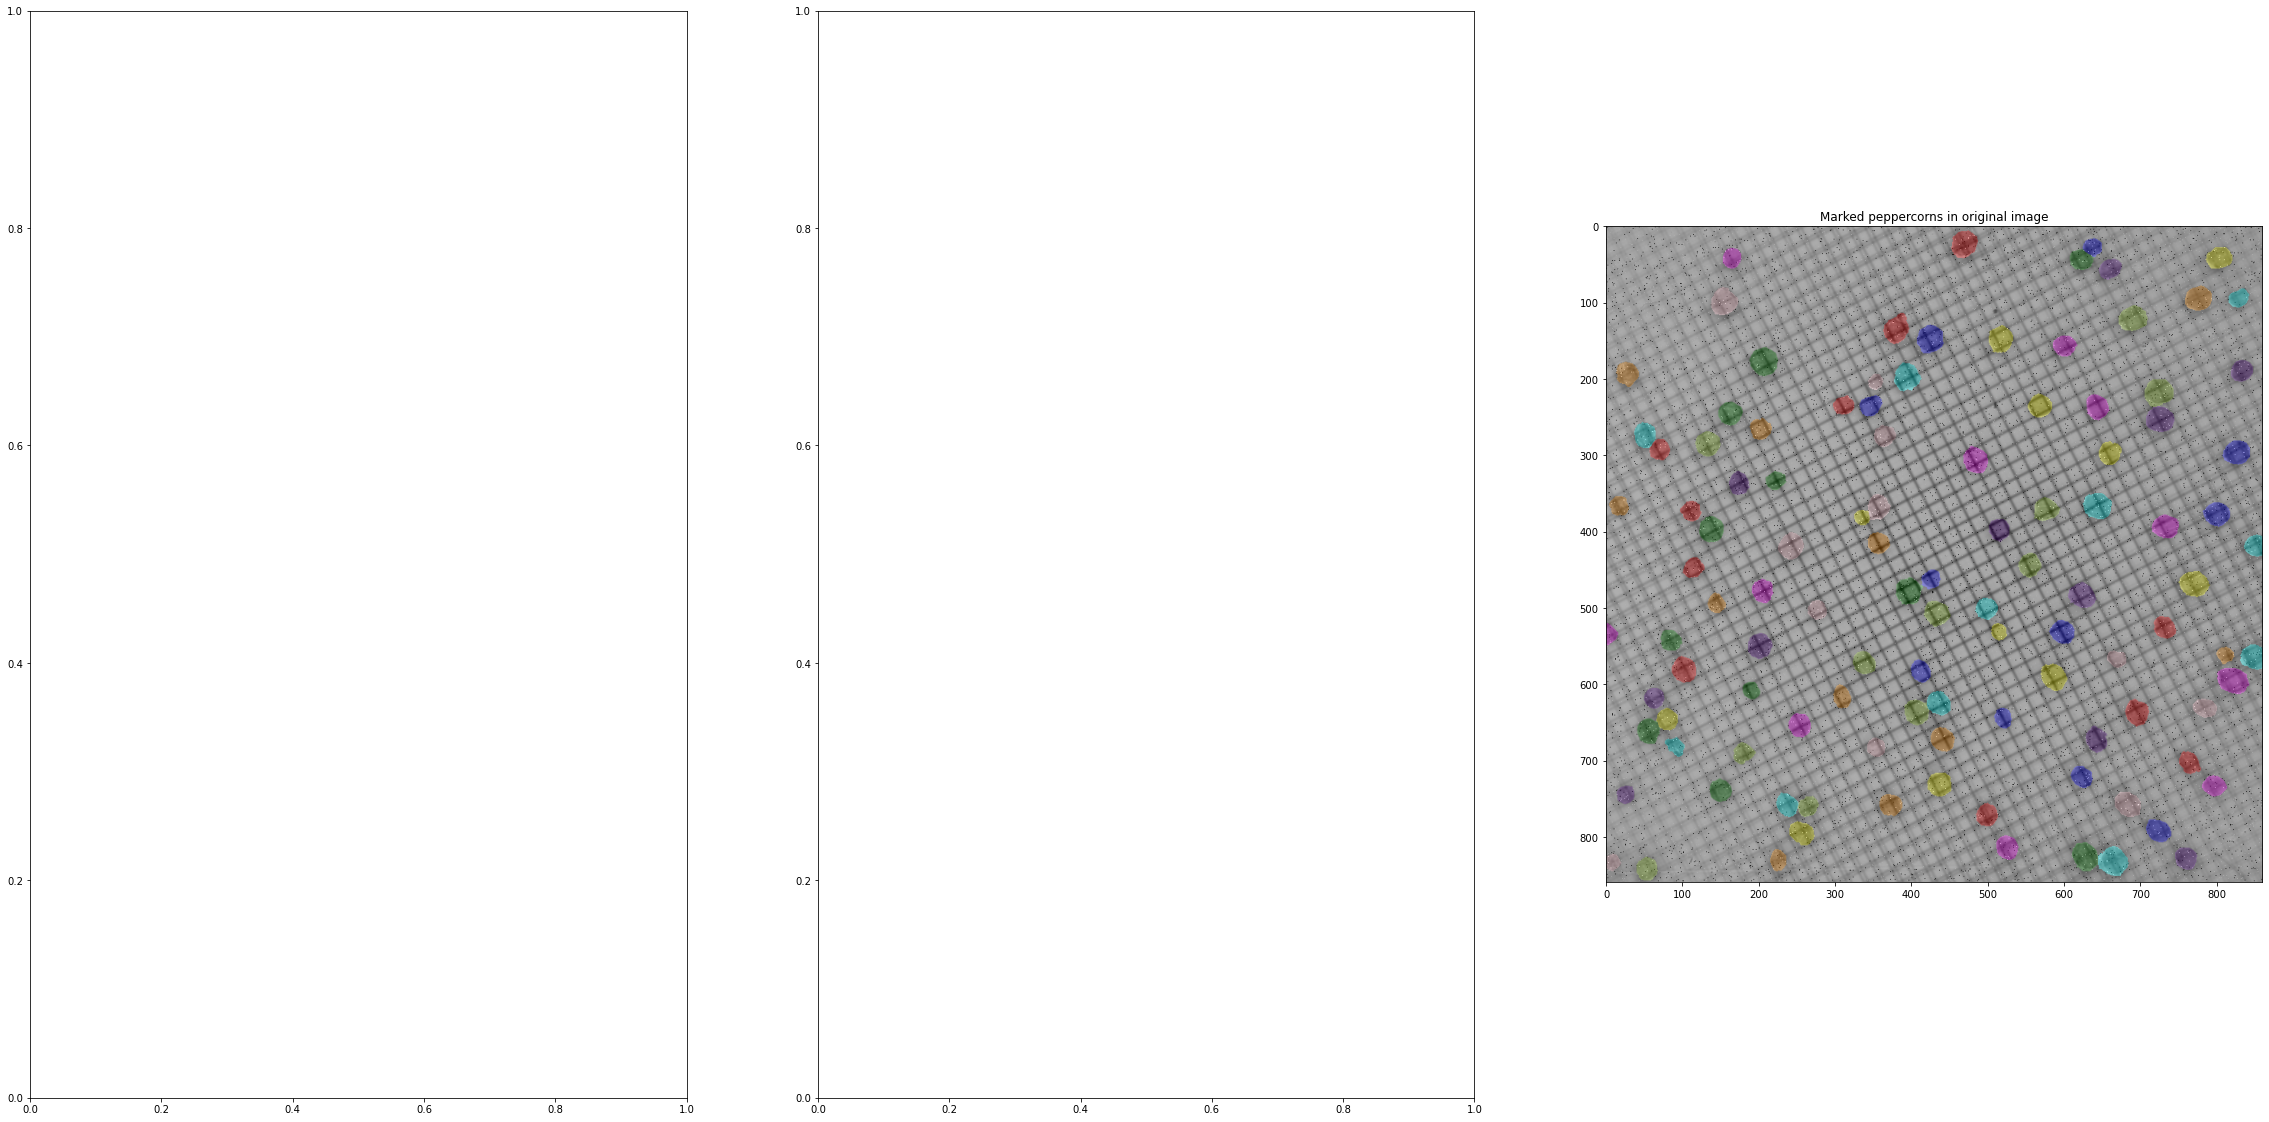

In [25]:
# Compute the distance from non-background to background
distance = ndimage.distance_transform_edt(erroded_bin_image)
# Pick the points with high intensity and minimal distance to next point (
coords = peak_local_max(distance, footprint=disk(10), labels=bin_image, min_distance=4)
mask = np.zeros(distance.shape, dtype=bool)
mask[tuple(coords.T)] = True
markers, _ = ndimage.label(mask)
labels = watershed(-distance, markers, mask=bin_image)

colored_labels = label2rgb(labels, image=input, bg_label=0)

fig, ax = plt.subplots(ncols=3, figsize=(40, 20))

ax[2].imshow(labels)
ax[2].set_title('Marked peppercorns in original image')
ax[2].imshow(colored_labels)


In [22]:
print("Count of peppercorns: " + str(markers.max()))

Count of peppercorns: 110
